# Notebook d'introduction à Scikit-learn

1. Présentation très rapide des différents cadres de machine-learning
2. Transposition dans l'univers sklearn (reposant lui-même sur numpy/matplotlib)
3. Prise en main des outils

# Plan:

* [A. Données](#a-les-données)
* [B. CLassifieurs (supervisés)](#b-classification-supervisée)
    * [B.1 Mise en oeuvre](#b1-mise-en-oeuvre-des-modèles)
    * [B.2 Evaluation, comparaison](#b2-evaluation--comparaison-de-modèles)
    * [B.3. Analyse quali sur des données jouet](#b3-analyse-qualitative-sur-les-données-jouets)
    * [B.4. Introspection des modèles](#b4-introspection-des-modèles)
    * [B.5. Généricité vs spécificté des modèles](#b5-spécificité-des-modèles)
    * [B.6. Focus sur l'arbre de décision](#b6-jouons-avec-un-arbre-de-décision)
    * [B.7. Focus sur le SVM](#b7-jouons-avec-le-svm)
* [C. Modèles de l'état de l'art (Forêt/XGB)](#c-modèles-de-létat-de-lart)
    * [C.1. Mise en oeuvre](#c1-premières-expérimentations)
    * [C.2. Introspection & explications](#c2-introspection-dans-un-modèle-linéaire-vs-xgboost-pondération-des-caractéristiques)
* [D. Extension de scikit-learn](#d-extension-de-scikit-learn)


In [ ]:
# très classique
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
from sklearn import datasets


## A. Les données

Quelques jeux de données classiques sont déjà dans la boite à outils, on va les utiliser pour aller plus vite. Evidemment, l'enjeux est ensuite de passer à des jeux de données plus proches de la réalité (e.g. challenge Kaggle) ou n'importe quel problème réel en important des données (csv, json, xls,...) à l'aide des fonctions existantes.

In [ ]:
# spécifique à scikit-learn
from sklearn import datasets

iris = datasets.load_iris()

# les données sont dans un dictionnaire python: 
# on regarde les clés
print("Structuration des donbées: ",iris.keys())
# puis les dimensions des valeurs d'intérêt
print("Dimension: ",iris.data.shape)

In [ ]:
# histoire de rendre les choses plus concretes: 
# tracé des deux premières variables (avec les couleurs en étiquettes)

X = iris.data
Y = iris.target

plt.figure(facecolor='white')
plt.scatter(X[:,0], X[:,1], c=Y) # on peut donner un vecteur de nombre pour les couleurs

### Données jouets

Afin de mieux comprendre la suite, on propose de travailler sur des données jouets, en 2D: ces données seront directement visualisables et permettent de comprendre le fonctionnement interne des classifieurs.

**Attention** à toujours garder en tête le coté *factice* des données 2d et à faire l'effort mental de transposer vos conclusions en plus haute dimensions.

In [ ]:
n   = 100
sig = 1.5
np.random.seed(42)  # reproductibilité
X = np.random.randn(n,2)*sig
Y = np.zeros(n)
Y[n//2:]=1          # moitié des données y=0 / moitié y=1
X[Y==0] += 2        # décalage des classes
X[Y==1] -= 2

plt.figure(facecolor='white')    # visu
plt.scatter(X[:,0], X[:,1], c=Y)
plt.grid()

In [ ]:
# séparation des indices d'apprentissage et de test
pcapp   = 0.7
ind     = np.random.permutation(len(X))
indapp  = ind[:int(pcapp*len(X))]
indtest = ind[int(pcapp*len(X)):]
Xapp,Yapp   = X[indapp],Y[indapp]
Xtest,Ytest = X[indtest],Y[indtest]

In [ ]:
# Visualiser les données d'apprentissage et de test avec un code de forme différent
# Classe 1 = jaune, Classe 2 = bleu
# App = ronds, Test = étoile

plt.figure(facecolor='white')
# <CORRECTION>
plt.scatter(X[indapp,0], X[indapp,1], c=Y[indapp])
plt.scatter(X[indtest,0], X[indtest,1], c=Y[indtest],marker='*', edgecolors="r")
plt.grid()
# </CORRECTION>

## B. Classification supervisée

Commençons par étudier quelques modèles classiques en classification supervisée... 

### B.1. Mise en oeuvre des modèles

Il s'agit de programmation objet et d'héritage... Mais pour l'utilisateur, c'est surtout un ensemble de modèles facilement disponible sur l'étagère.

1. Initialisation du modèle & des paramètres (=création du classifieur)
2. Apprentissage sur les données d'entrainement (=`fit`)
3. Inférence sur les données d'apprentissage ou de test (=`predict`)<BR>
  ATTENTION: predict attend un ensemble de données, pas une seule

In [ ]:
from sklearn import svm,linear_model, naive_bayes

# creation d'un modèle bayesien naïf
mod = naive_bayes.GaussianNB() 
# apprentissage sur les données d'apprentissage
mod.fit(Xapp, Yapp)
# inférence, sur un individu (le premier point de test)
yhat = mod.predict([Xtest[0]])      # attention, la fonction est
                                    # prévue pour traiter un ensemble de points
                                    # et pas une seule donnée
                                    # d'où les [] supplémentaires
                                    # => La fonction retourne une liste de prédictions

print("comparaison entre prédiciton et vérité terrain: ", yhat, Y[indtest[0]])

In [ ]:
# Parfois on veut prédire une CLASSE, parfois on veut un SCORE
# 1. classe => plus simple pour les métriques (e.g. tx bonne classif)
# 2. score  => important pour la mesurer la confiance, la distance à la frontière etc...

yhat  = mod.predict([Xtest[0]])   
score = mod.predict_proba([Xtest[0]])   # predict_proba... Même pour les modèles non bayesien
                                        # ATTENTION: un score par classe (dim != yhat)

print(yhat, score)

### <span style="color:red"> Mini-exo</span> (rappels de numpy)

1. Calculer à la main le taux de bonne classification à partir d'une sortie probabiliste
2. En admettant un taux de rejet des points les plus ambigus (5%), que devient le taux de bonne classification sur les 95% restants?

**Rappel**: il s'agit d'une technique de rejet qui peut être très utile en contexte opérationnel

In [ ]:
yhat_prob = mod.predict_proba(Xtest)
# calculer le taux de bonne classification par rapport à Ytest
# <CORRECTION>
tx = np.where(yhat_prob.argmax(1) == Ytest,1., 0).mean()
print(tx)
# </CORRECTION>

# trouver les indices des 95% des points les moins ambigus
# calculer le taux de bonne classification sur ces points
# <CORRECTION>
ind80 = np.argsort(np.abs(yhat_prob[:,0]-yhat_prob[:,1]))[int(.05*len(Ytest)):]
tx = np.where(yhat_prob[ind80].argmax(1) == Ytest[ind80],1., 0).mean()
print(tx)
# </CORRECTION>

### <span style="color:red"> Mini-exo</span> Passage en plus grande dimension

Le classifieur utilisé `naive_bayes.GaussianNB()` correspond à l'une des solutions envisagée pour les données USPS dans un des notebook précédent: vérifier que vous êtes capable d'évaluer ce classifieur sur les données USPS 

In [ ]:
# 1. chargement des données
import pickle as pkl
data = pkl.load(open("data/usps.pkl",'rb')) 
# data est un dictionnaire contenant les champs explicites X_train, X_test, Y_train, Y_test
Xu_train = np.array(data["X_train"],dtype=float) # changement de type pour éviter les problèmes d'affichage
Xu_test = np.array(data["X_test"],dtype=float)
Yu_train = data["Y_train"]
Yu_test = data["Y_test"]

# 2. apprentissage du modèle
# <CORRECTION>
modu = naive_bayes.GaussianNB()
modu.fit(Xu_train,Yu_train)
# </CORRECTION>

# 3. Eval: quel taux de bonne classification?
# <CORRECTION>
yuhat = modu.predict(Xu_test)
tx = np.where(yuhat == Yu_test,1., 0).mean()
print(tx)
# </CORRECTION>

### B.2 Evaluation & comparaison de modèles

Un des enjeux du machine learning consiste à choisir le modèle qui marche le mieux pour un problème donné.
L'architecture de `sklearn` est particulièrement performante pour répondre à cette question.

In [ ]:
# comparaison simple de modèles
mod1 = naive_bayes.GaussianNB()
mod2 = svm.SVC()

mod1.fit(Xapp, Yapp)
mod2.fit(Xapp, Yapp)

yhat1 = mod1.predict(Xtest)
yhat2 = mod2.predict(Xtest)

print("perf modèle 1 ", np.where(yhat1 == Ytest,1,0).mean())
print("perf modèle 2 ", np.where(yhat2 == Ytest,1,0).mean())

#### Sélection des paramètres d'un modèle

La plupart des modèles ont des hyper-paramètres qui impactent beaucoup les performances... cf exemple ci-dessous.
Il faut donc comprendre aussi la sélection de modèle comme une manière d'optimiser les hyper-paramètres.

In [ ]:
mod_SVM1 = svm.SVC(kernel="linear", probability=True)   # proba pour les affichages avancés ci-dessous
mod_SVM2 = svm.SVC(gamma = 10, probability=True)

mod_SVM1.fit(Xapp, Yapp)
mod_SVM2.fit(Xapp, Yapp)

yhat1 = mod_SVM1.predict(Xtest)
yhat2 = mod_SVM2.predict(Xtest)

print("perf modèle 1 ", np.where(yhat1 == Ytest,1,0).mean())
print("perf modèle 2 ", np.where(yhat2 == Ytest,1,0).mean())


### B.3 Analyse qualitative sur les données jouets

Traçons les frontières de décisions pour comprendre les modèles... Evidemment, on ne peut tracer ces fonctions qu'en 2D.

Note 1: la fonction de tracé de la frontière est un peu complexe, pas besoin de comprendre en profondeur (ou alors demander au prof.)

Note 2: la fonction est donnée... Mais pas dans le notebook: afin de rendre le code plus clair, les fonctions de tracé sont dans un module externe (= un répertoire avec des fichiers de code).

1. Les modules sont (très) importants en python. Il faut apprendre à les utiliser, puis à en faire
    * un répertoire contenant un fichier `__init__.py` (vide dans un premier temps)
    * un ou plusieurs fichiers contenant des fonctions

2. L'interface entre un notebook et un module peut être complexe: en effet, par défaut, les modifications du module ne sont pas prise en compte, il faut ajouter des options.


In [5]:
# répertoire outils
# fichier frontiere
# plusieurs fonctions dans le fichier
from outils.frontiere import plot_frontiere

%load_ext autoreload
%autoreload 2

In [ ]:
# cas d'usage

plt.figure(figsize=(12,4), facecolor='white')
plt.subplot(1,3,1) # indicage foireux hérité de matlab :)
plot_frontiere(Xapp, Yapp, mod1)
plt.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
plt.title('Naive Bayes')
plt.subplot(1,3,2)
plot_frontiere(Xapp, Yapp, mod_SVM1)
plt.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
plt.title('SVC')
plt.subplot(1,3,3)
plot_frontiere(Xapp, Yapp, mod_SVM2)
plt.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
plt.title('SVC (2)')

Pour les classifieurs qui possède la méthode `predict_proba` (tous ou presque tous... A condition d'avoir mis les bonnes options à la création), j'ai développé une méthode `plot_mesh` qui permet de voir la fonction de décision en 3D...

1. Importer cette fonction de mon module (vérifier éventuellement son existance dans `frontiere.py`)
1. Ouvrir une figure 3D (code donné ci-dessous)
1. Utiliser la fonction. ATTENTION, la fonction ne marche que sur les classifieurs SVM :)

In [ ]:
# 1. effectuer l'import correctement

from outils.frontiere import *
# 2. ouverture de la figure
fig = plt.figure(facecolor='white', figsize=(10,8))
ax = fig.add_subplot(projection='3d') # ATTENTION, il faut ouvrir une figure 3D pour avoir droit à ma fonction

# 3. appel de la fonction
plot_mesh(Xapp, Yapp, mod_SVM2)


### B.4. Introspection des modèles

Que valent les paramètres appris? Idéalement, que signifient-ils? 

<span style="color:red"> ATTENTION: les modèles ont évidemment des paramètres spécifiques => trouver les paramètres à explorer = lire la documentation de chaque modèle</span>

1. On passe par la documentation pour savoir quoi regarder: <BR>
e.g. : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

2. On va chercher les paramètre pour les afficher

In [ ]:
# Naive Bayes: 2 variables => 2 gaussiennes... Par classe 

print(mod1.sigma_) # ou .var_ si vous avez une version récente de sklearn
print(mod1.theta_)


[Exercice] Dans les SVM, la régularisation fait que la solution ne repose que sur quelques points (les vecteurs supports). Faire en sorte d'afficher les points qui supportent la solution dans le cas linéaire:

```mod = svm.SVC(kernel='linear')```

<img src=fig/svm_support_1.png>

In [ ]:
# Generation des figures du cours (Hors sujet pour le TP)
### <CORRECTION> ###
from outils.frontiere import plot_mesh,plot_svm


Xapp = Xapp[:20]
Yapp = Yapp[:20]

mod_SVM1 = svm.SVC(kernel="linear")
mod_SVM2 = svm.SVC(gamma = 10, C=10)
mod_SVM3 = svm.SVC(gamma = 1, C=1e9)



mod_SVM1.fit(Xapp, Yapp)
mod_SVM2.fit(Xapp, Yapp)
mod_SVM3.fit(Xapp, Yapp)


support1 = mod_SVM1.support_
support2 = mod_SVM2.support_
support3 = mod_SVM3.support_

plt.figure()
plot_svm(Xapp, Yapp, mod_SVM1)
plt.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
plt.scatter(Xapp[support1,0], Xapp[support1,1], edgecolor='k',marker='s',s=100,facecolors="none")
plt.savefig("fig/svm_marge.png")

plt.figure()
plot_frontiere(Xapp, Yapp, mod_SVM1)
plt.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
plt.scatter(Xapp[support1,0], Xapp[support1,1], edgecolor='k',marker='s',s=100,facecolors="none")
plt.savefig("fig/svm_support_1.png")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_mesh(Xapp, Yapp, mod_SVM1, ax)
ax.scatter(Xapp[:,0], Xapp[:,1], 0, c=Yapp)
ax.scatter(Xapp[support1,0], Xapp[support1,1], 0, edgecolor='k',marker='s',s=100,facecolors="none")
plt.savefig("fig/svm_support_3d_1.png")


# print(support1)
# plt.figure()
plt.figure(figsize=(12,4))
plt.subplot(1,3,1) # indicage foireux hérité de matlab :)
plot_frontiere(Xapp, Yapp, mod_SVM1)
plt.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
plt.scatter(Xapp[support1,0], Xapp[support1,1], edgecolor='k',marker='s',s=100,facecolors="none")

plt.title('SVC linéaire')
plt.subplot(1,3,3)
plot_frontiere(Xapp, Yapp, mod_SVM2)
plt.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
plt.scatter(Xapp[support2,0], Xapp[support2,1], edgecolor='k',marker='s',s=100,facecolors="none")

plt.title('SVC gaussien')
plt.subplot(1,3,2)
plot_frontiere(Xapp, Yapp, mod_SVM3)
plt.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
plt.scatter(Xapp[support3,0], Xapp[support3,1], edgecolor='k',marker='s',s=100,facecolors="none")

plt.title('SVC gaussien')
plt.savefig("fig/svm_support2.png")


fig = plt.figure(figsize=(18,6))
# ax = fig.add_subplot(projection='3d')

ax = fig.add_subplot(1,3,1,projection='3d')
plot_mesh(Xapp, Yapp, mod_SVM1, ax)
ax.scatter(Xapp[:,0], Xapp[:,1], 0, c=Yapp)
ax.scatter(Xapp[support1,0], Xapp[support1,1], 0, edgecolor='k',marker='s',s=100,facecolors="none")

ax = fig.add_subplot(1,3,3,projection='3d')
plot_mesh(Xapp, Yapp, mod_SVM2, ax)
ax.scatter(Xapp[:,0], Xapp[:,1],0, c=Yapp)
ax.scatter(Xapp[support2,0], Xapp[support2,1],0, edgecolor='k',marker='s',s=100,facecolors="none")

ax = fig.add_subplot(1,3,2,projection='3d')
plot_mesh(Xapp, Yapp, mod_SVM3, ax)
ax.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
ax.scatter(Xapp[support3,0], Xapp[support3,1],0, edgecolor='k',marker='s',s=100,facecolors="none")


plt.savefig("fig/svm_support_3d.png")

### </CORRECTION> ###

### B.5. Spécificité des modèles

Afin de faciliter leur utilisation, tous les modèles disposent de `fit` et `predict` (et aussi de `score`)... Mais les modèles peuvent aussi avoir des spécificités qui apparaissent dans la documentation. 
> <span style="color:magenta"> Vous devez exploiter la généricité des architectures ET la spécificité des modèles :) </span>

Par exemple, sur le modèle NB gaussien, il est possible d'obtenir la vraisemblance de chaque point évalué pour chaque classe, ce qui ouvre des perspectives applicatives telles que le rejet des points ambigus.

Vous devriez obenir quelque chose de la forme:
<img src="./fig/vraisemblance.png">

Note: évidemment, la vraisemblance n'est tracée que pour l'une des deux classes..

In [ ]:
# Afficher la vraisemblance des points en couleur

### <CORRECTION> ###

lv=mod1.predict_proba(Xapp)
print(lv.shape)

plt.figure(facecolor='white')
plt.scatter(Xapp[:,0], Xapp[:,1], c=lv[:,0])
plt.colorbar()

plt.savefig("fig/vraisemblance.png")

### </CORRECTION> ###

### B.6. Jouons avec un arbre de décision

Les arbres de décision ont un statut particulier: à cheval entre l'apprentissage symbolique et statistique... Un petit exercice autour de ce modèle.

La plupart des réponses se trouvent [ici](https://scikit-learn.org/stable/modules/tree.html)

Voici les questions: 
1. Construire le modèle par défaut et l'entrainer
2. Visualiser la frontière de décision puis l'algorithme de décision... Et réfléchir à la manière dont fonctionne cette décision. Pourquoi considère-t-on que ce modèle est plus explicable que d'autres?

Note: vous devez obtenir quelque chose de la forme : 

<img src="fig/tree_decision_c.png"> <img src="fig/tree_decision_2d.png"><BR>
Bonus: trouver le nom de l'option qui colorie les branche de l'arbre en fonction de la classe d'affectation.


3. Entrainer et visualiser un arbre de profondeur limitée à 1 puis 2 et analyser le résultat



In [ ]:
from sklearn import tree

# Construction & apprentissage du modèle
### <CORRECTION> ###

mod = tree.DecisionTreeClassifier()
mod.fit(Xapp,Yapp)

### </CORRECTION> ###

# visualisation du modèle
plt.figure(facecolor='white')
plot_frontiere(Xapp, Yapp, mod) # si votre modèle ne s'appelle pas mod => mettre à jour
plt.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
# plt.savefig('fig/tree_decision_2d.png')

# dessin de l'algorithme de décision
### <CORRECTION> ###
plt.figure(facecolor='white')
tree.plot_tree(mod, filled=True)
#plt.savefig('fig/tree_decision.png')
### </CORRECTION> ###

# Entrainer et visualiser un arbre de profondeur 1 puis 2
### <CORRECTION> ###

mod = tree.DecisionTreeClassifier(max_depth=1)
mod.fit(Xapp,Yapp)
mod2 = tree.DecisionTreeClassifier(max_depth=2)
mod2.fit(Xapp,Yapp)
plt.figure(facecolor='white',figsize=[10,5])
plt.subplot(1,2,1)
plot_frontiere(Xapp, Yapp, mod) # si votre modèle ne s'appelle pas mod => mettre à jour
plt.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
plt.subplot(1,2,2)
plot_frontiere(Xapp, Yapp, mod2) # si votre modèle ne s'appelle pas mod => mettre à jour
plt.scatter(Xapp[:,0], Xapp[:,1], c=Yapp)
plt.figure(facecolor='white',figsize=[10,5])
plt.subplot(1,2,1)
tree.plot_tree(mod, filled=True)
plt.subplot(1,2,2)
tree.plot_tree(mod2, filled=True)
#plt.savefig('fig/tree_decision_1vs2.png')
### </CORRECTION> ###


### B.7. Jouons avec le SVM

Comparer un classifieur SVM avec un noyau linéaire et un noyau gaussien.

1. Tracer les frontières de décision
1. Jouer avec la largeur de bande des gaussiennes
1. Mettre en évidence le phénomène de sur-apprentissage (très rapide avec les gaussiennes trop serrées)

Afin de tirer parti des capacités non linéaire des SVM, nous allons travailler sur des données non séparable linéairement

In [ ]:
from sklearn.datasets import make_blobs

centers = [[float(i),float(j)] for i in range(5) for j in range(5)]
print(centers)
clusters_std = 0.2
X, y = make_blobs(n_samples=100, centers=centers, cluster_std=clusters_std,  n_features=2,   random_state=0)
y = (y % 2)*2 - 1 

print(X.shape)
plt.figure(facecolor='white')
plt.scatter(X[:,0], X[:,1], c=y)


# C Modèles de l'état de l'art

Si les approches bayesiennes sont rapides et que les SVM forment une référence solide, il faut admettre aujourd'hui l'efficacité redoutable des approches ensemblistes sur un grand nombre de taches.

Parmi toutes les approches de bagging / boosting, deux modèles s'illustrent particulièrement: les forêts aléatoires et le gradient boosting.

1. Forêt aléatoire : [lien](https://en.wikipedia.org/wiki/Random_forest)
    - les arbres comportent une part aléatoire dans leur construction (ils fonctionnent sur un sous-ensemble de variables)... Ils sont donc individuellement assez faibles
    - le mécanisme de vote rend l'ensemble de la forêt très efficace.
    - [lien vers le classifieur sklearn](https://scikit-learn.org/stable/modules/ensemble.html?highlight=random+forest#forests-of-randomized-trees)


2. Gradient boosting
    - très grossièrement: il s'agit d'une forêt où les arbres sont ajoutés itérativement pour réduire les erreurs de forêt à l'itération précédente.
    - l'implémentation sklearn est intéressante [lien](https://scikit-learn.org/stable/modules/ensemble.html?highlight=random+forest#gradient-tree-boosting)... Mais la plus efficace (rapide + hardware acceleration + super paramètres par défaut + interprétation) est XGboost [lien](https://xgboost.readthedocs.io/en/stable/)
    - il existe une interface sklearn pour XGBoost... Ca s'utilise donc comme tous les autres modèles
    - Depuis 2022, il semble que `catboost` supplante xgboost, notamment dans les cas où il y a des variables catégorielle

<img src="fig/xgboost_the_things.jpg">

## C.1. Premières expérimentations

Pour les deux modèles:
1. Entrainer le modèle de base
2. Visualiser la frontière de décision
3. Essayer de jouer avec les paramètres: au moins le nombre d'arbres + leur profondeur
4. [OPT] Reprendre les données USPS et comparer les performances de ces approches par rapport aux classifieurs bayesien naïf

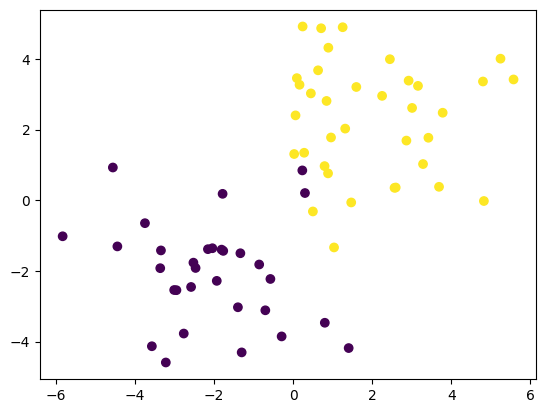

In [3]:
# Re-générer des données (avec sklearn)
# 1. Trouver la bonne fonction
# 2. Trouver la séparation des données app/test

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

centers = [[-2.0, -2.0], [2.0, 2.0]]
clusters_std = [1.5, 1.5]
X, y = make_blobs(n_samples=100, centers=centers, cluster_std=clusters_std,  n_features=2,   random_state=0) # 100 pts, 2classes, 2dim 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

plt.figure(facecolor='white')
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)

perf modèle RF 0.9696969696969697


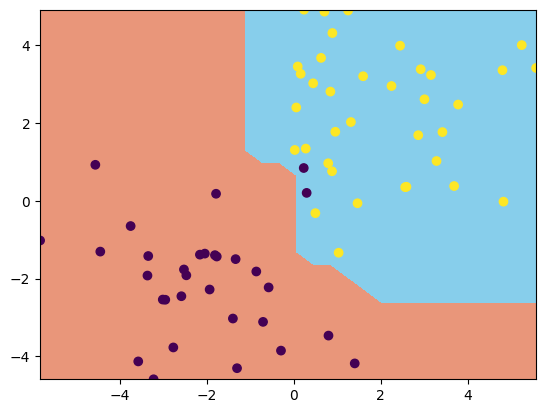

In [6]:
# Foret aléatoire sklearn
from sklearn.ensemble import RandomForestClassifier

mod =  RandomForestClassifier()
mod.fit(X_train,y_train)

# Evaluation quantitative
yhat = mod.predict(X_test)
print("perf modèle RF", np.where(yhat == y_test,1,0).mean())

# Trace de la frontière
plt.figure(facecolor='white')
plot_frontiere(X_train, y_train, mod) # si votre modèle ne s'appelle pas mod => mettre à jour
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)


In [7]:
# Information de base sur le modèle appris:
print("nb arbres : ", mod.n_estimators)
print("profondeur des arbres : ", mod.max_depth) # on a laissé le pararmètre par défaut... Comment trouver cette valeur?
print("profondeur des arbres (bis, pour les 10 premiers): ", [mod.estimators_[i].get_depth() for i in range(10)]) 

nb arbres :  100
profondeur des arbres :  None
profondeur des arbres (bis, pour les 10 premiers):  [4, 5, 3, 3, 4, 3, 4, 3, 3, 4]


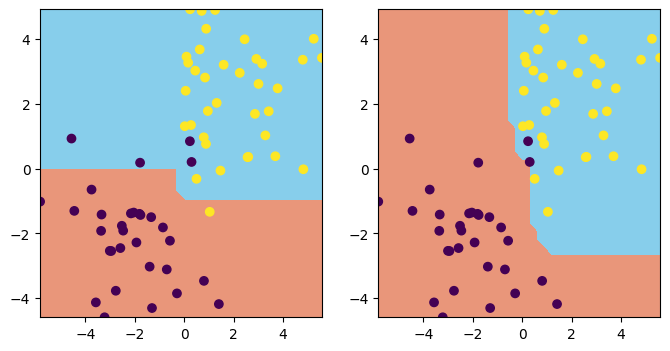

In [8]:
# Jeu avce les paramètre de la foret aléatoire (code donné)

mod1 =  RandomForestClassifier(max_depth=1,n_estimators=5) # tres simple
mod1.fit(X_train,y_train)

mod2 =  RandomForestClassifier(max_depth=10,n_estimators=100) # tres simple
mod2.fit(X_train,y_train)

# Trace de la frontière
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plot_frontiere(X_train, y_train, mod1) 
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.subplot(1,2,2)
plot_frontiere(X_train, y_train, mod2,step=40) 
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

# N'hésitez pas à complexifier les données et relncer de bout de code


In [ ]:
# XGboost

import xgboost as xgb # !pip install xgboost # en cas de besoin

bst = xgb.XGBClassifier().fit(X_train,y_train) # pour passer par l'interface sklearn
# make prediction
yhat = bst.predict(X_test)

print("perf modèle XGB", np.where(yhat == y_test,1,0).mean())

# Trace de la frontière
plt.figure(facecolor='white')
plot_frontiere(X_train, y_train, bst) # si votre modèle ne s'appelle pas mod => mettre à jour
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

## C.2 Introspection dans un modèle linéaire vs XGBoost: pondération des caractéristiques

Si on crée le jeu de données jouet suivant:

$$X = \begin{pmatrix}  x_{11}& x_{12} & x_{13} \sim \mathcal N(0,\sigma) & \ldots & x_{1d} \sim \mathcal N(0,\sigma) \\
x_{21}& x_{22} & x_{23} \sim \mathcal N(0,\sigma) & \ldots & x_{2d} \sim \mathcal N(0,\sigma) \\
\vdots& \vdots & \vdots & \ddots &\vdots \\
x_{n1}& x_{n2} & x_{n3} \sim \mathcal N(0,\sigma) & \ldots & x_{nd} \sim \mathcal N(0,\sigma) \\
\end{pmatrix} ,\qquad
Y = \begin{pmatrix}  y_{1} \\
y_{2}\\
\vdots\\
y_{n} \\
\end{pmatrix} ,\qquad y_i\in\{0,1\}
$$

Il s'agit d'un problème où les deux premières colonnes ont du sens et dans lesquelles on a ajouté des colonnes de bruit blanc. La visualisation des deux premières colonnes avec les étiquettes donne classiquement: 

<img src="fig/data2d.png"> 

La question qui se pose:
> <span style="color:magenta"> Est-on capable de donner un score aux différentes colonnes, une fois l'apprentissage effectué?</span>

1. Avec les modèles linéaire, la réponse est triviale: il suffit de regarder les coefficients du classifieur
1. Avec une approche ensembliste, c'est possible aussi et c'est déjà implémenté: il suffit d'aller chercher les bonnes méthodes

Pour l'explication des combinaisons qui sont calculées (et les risques de sur-interprétation): [lien](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)


In [ ]:
# données
centers = [[-2.0, -2.0], [2.0, 2.0]]
clusters_std = [1.5, 1.5]
X, y = make_blobs(n_samples=50, centers=centers, cluster_std=clusters_std,  n_features=2,   random_state=0) # 100 pts, 2classes, 2dim 

# ajout de bruit
ndim_noise = 20
Noise = np.random.randn(len(X), ndim_noise)*clusters_std[0]
Xn = np.concatenate((X,Noise), axis=1)

# split
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.33, random_state=0)

In [ ]:
plt.figure(facecolor='white')
plt.scatter(X[:,0],X[:,1],c=y)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

# plt.savefig("fig/data2d.png")

In [ ]:
from sklearn.linear_model import LogisticRegression
# Apprentissage d'un modèle lineaire
mod1 = LogisticRegression()
mod2 = xgb.XGBClassifier()

mod1.fit(X_train,y_train)
mod2.fit(X_train,y_train)


Pour le modèle linéaire, vous devez être capable :
1. d'aller chercher les paramètres
1. de tracer un diagramme `plt.bar` de ces paramètres 
    - à vous de choisir si vous optez pour la valeur absolue ou pas: les deux choix sont argumentables
    - vous ferez attention à la dimension des paramètres

<img src="fig/bar_mod_lin.png">

In [ ]:
# affichage des poids associées aux caractéristiques du problème

### <CORRECTION> ###

#print(np.arange(X_train.shape[1]),mod1.coef_)

plt.figure(facecolor='white')
plt.bar(np.arange(X_train.shape[1]), mod1.coef_[0])
plt.title('Poids (Intercept = '+str(mod1.intercept_)+')')
# plt.savefig("fig/bar_mod_lin.png")

### </CORRECTION> ###

Faire la même chose XGBoost en allant chercher la (les) fonction(s) utile(s) dans la documentation

## D. Extension de scikit-learn

Selon les principes de la programmation objet, vous pouvez définir votre propre classifieur et utiliser ensuite toutes les fonctions qui attendent un classifieur (validation croisée, grid search...)

Voici un code minimaliste illustrant l'héritage en python (très simple) dans le cas sklearn:

Pour plus de détails: [lien](https://scikit-learn.org/stable/developers/develop.html)


In [ ]:
# un classifieur à poids fixes (un peu absurde donc...) Mais qui montre comment ça marche
from sklearn.base import BaseEstimator, ClassifierMixin

class LinearFixClassifier(BaseEstimator, ClassifierMixin):
     def __init__(self, data_dim=2): # on  a besoin de connaitre la dimension des données
         self.data_dim = data_dim # il faut stocker tous les attributs pour la sérialisation des modèles.
         self.w = np.random.randn(data_dim) # init

     def fit(self, X, y):
         # On a rien besoin de faire dans notre cas...
         # Store the classes seen during fit
         self.classes_ = np.unique(y)
         # on stocke tout pour simplifier les choses après (fonction score)   
         self.X_ = X
         self.y_ = y
         # Return the classifier
         return self

     def predict(self, X): # dans le cas binaire seulement

         # Check if fit has been called
         # check_is_fitted(self)

         # Input validation
         # X = check_array(X)
         
         # mon classifieur sort dans -1,1 et je remets ensuite les étiquette par rapport aux y
         return np.where(X@self.w > 0, self.y_[0] , self.y_[1] )


A vous de vérifier que vous pouvez invoquer une validation croisée sur ce classifier !

In [ ]:
# données
centers = [[-2.0, -2.0], [2.0, 2.0]]
clusters_std = [1.5, 1.5]
X, y = make_blobs(n_samples=50, centers=centers, cluster_std=clusters_std,  n_features=2,   random_state=0) # 100 pts, 2classes, 2dim 

mod = LinearFixClassifier(2)
mod.fit(X,y)
yhat = mod.predict(X)

print(yhat)

# ajouter de la validation croisée (plus ambitieux => Une autre fonction, que je ne connais pas, va utiliser mon objet !)

In [ ]:
from sklearn.model_selection import cross_val_score

n_fold = 5
scores = cross_val_score(mod, X, y, cv=n_fold, scoring='accuracy') # tout est caché dedans :)
print(scores)

----
# Annexe: transformation du notebook en version étudiante

In [1]:
### <CORRECTION> ###
import re
# transformation de cet énoncé en version étudiante

fname = "1-notebook-intro-corr.ipynb" # ce fichier
fout  = fname.replace("-corr","")

# print("Fichier de sortie: ", fout )

f = open(fname, "r")
txt = f.read()

f.close()


f2 = open(fout, "w")
f2.write(re.sub("<CORRECTION>.*?(</CORRECTION>)"," TODO ",\
    txt, flags=re.DOTALL))
f2.close()

### </CORRECTION> ###